#Hillary Talks

I am analysing the HCM dataset to identify trends in the foreign policy along the time. The work is based on the approach by [Olalekan](https://www.kaggle.com/ampaho/d/kaggle/hillary-clinton-emails/foreign-policy-map-through-hrc-s-emails/code) but extended to the whole dataset. It is also mainly in python instead of R as Olalekan code, but inserts R code in particular to use the R's countrycode package. I applied some modifications on the proposed job by Olalekan.

Also in the same fashion as Olalekan I added a visualization but in d3.js that can be found on [this link]().

The second part of this project is very much in the same fashion as [D Kelly](https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb) with some small modifications. I copied some of his work and made a few modifications. Both works are absolutely comparable in methodology but not totally on results.

The code below is far from being optimised and it is for "playing" purposes. It was based on python3 and used recent extensions for connecting to R.


In [1]:
import os, sys
import csv
#http://blog.revolutionanalytics.com/2016/01/pipelining-r-python.html
%load_ext rpy2.ipython
import numpy, scipy, pandas
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
from collections import Counter
import datetime
import sqlite3
import zipfile
import nltk, re
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Modeling: Part 1
#from textblob import TextBlob
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

conn = sqlite3.connect('.../output/database.sqlite')
c = conn.cursor()

###Extraction of data (mails and dates) from SQLite to pandas

In [2]:
import pandas.io.sql as psql
sql = "SELECT MetadataSubject as MetadataSubject, SUBSTR(MetadataDateSent,1,7) as SentFOIA, ExtractedDateSent as Sent, ExtractedBodyText as EmailBody FROM Emails a WHERE ExtractedBodyText != '' AND MetadataDateSent != '' ORDER BY MetadataDateSent"
df = psql.frame_query(sql, conn)
#df = df.iloc[:100,:]
#df
#sql2 = "SELECT SUBSTR(MetadataDateSent,1,7) as SentFOIA, ExtractedDateSent as Sent, ExtractedBodyText as EmailBody, RawText FROM Emails a WHERE ExtractedBodyText != '' AND MetadataDateSent != '' ORDER BY MetadataDateSent"
#df2 = psql.frame_query(sql2, conn)
#df['EmailBody'][4]

./lib/python3.4/site-packages/pandas/io/sql.py:1569: FutureWarning: frame_query is deprecated, use read_sql
  warnings.warn("frame_query is deprecated, use read_sql", FutureWarning)


###Using and preparing R's countrycode dataset

In [3]:
%%R -o words_to_be_removed -o countries
library(qdapDictionaries)
library(countrycode)
data(countrycode_data)
#we assume that a country could be referred to as its full name or its ISO3 code
#ec:: OJO with above ^^
#as abbreviation so we get the list of countries
#ec:: list of country names that will be not considered, including USA
#ec:: USA (255) is excluded because we are interested only in foreign policy

#countrycode_data[,c('country.name','iso2c','iso3c','regex')]

words_to_remove <- rbind(DICTIONARY[nchar(DICTIONARY$word)==2,], DICTIONARY[nchar(DICTIONARY$word)==3,])
words_to_be_removed <- toupper(c(words_to_remove$word, "RE", "FM", "TV", "LA", "AL", "BEN", "AQ"))

## ec:: the only accepted countries
## ec:: as we will see later, regex is a prepared dataset that includes a pattern to find country.name (NICE!!!)
#countries <- countrycode_data[, c("country.name", "regex", "iso2c", "iso3c")]
#countries <- countrycode_data[-83,]


#countries$other <- NA
## ec:: not clear for me why UK is left apart as "other"
#countries[countries$country.name=="United Kingdom",]$other <- "UK"
##head(countrycode_data_without_atf)
##head(countries)
##countries[countries$country.name=="United Kingdom",]
##countrycode_data_without_atf[with(countrycode_data_without_atf,  grepl("Russia", country.name)),]
##countries[countries$country.name=="Saint Pierre and Miquelon"]
#countrycode_data[countrycode_data$country.name == 'Haiti',]

 countries <- countrycode_data                   [-c(2,
                                                     5,
                                                     6,
                                                     9,
                                                     16,
                                                     23,
                                                     31,
                                                     32,
                                                     34,
                                                     36,
                                                     50,
                                                     51,
                                                     56,
                                                     61,
                                                     64,
                                                     66,
                                                     76,
                                                     77,
                                                     83,
                                                     87,
                                                     88,
                                                     91,
                                                     98,
                                                     103,
                                                     104,
                                                     105,
                                                     106,
                                                     117,
                                                     122,
                                                     130,
                                                     143,
                                                     154,
                                                     155,
                                                     158,
                                                     177,
                                                     183,
                                                     188,
                                                     191,
                                                     201,
                                                     202,
                                                     203,
                                                     204,
                                                     205,
                                                     206,
                                                     207,
                                                     209,
                                                     210,
                                                     212,
                                                     215,
                                                     218,
                                                     224,
                                                     230,
                                                     241,
                                                     248,
                                                     249,
                                                     250,
                                                     255,
                                                     256,
                                                     262,
                                                     263,
                                                     264,
                                                     266,
                                                     270),] 
 


#countries

###End of Sentence Detection; Tokenization; POS tagging; Word Removal

In [4]:
#df = df.iloc[0:30,:]

def EoS(t):
    return nltk.tokenize.sent_tokenize(t)

def Tok(ss):
    return [nltk.tokenize.word_tokenize(s) for s in ss]

def POS(ts):
    return [nltk.pos_tag(t) for t in ts]


usual_stopwords = nltk.corpus.stopwords.words('english')

punctuation = ["(",")",".",",",":","=","{","}","==", "===","[","]","+","++","-","--","_","<",">","'","''","``",'"',"!","!=","?",";","/","\\", "\\\\", "/", "//"]

#from Doug Kelly work
specific_stopwords = ['foia', 'waiver', 'classified', 'unclassified', 
                 'redactions', 'sensitive', 'clintonemail', 'department', 
                 'dept', 'mailto', 'subject', 'fw', 'cc', 'state', 'send', 
                 'sent', 'comm', 'cheryl', 'mills', 'sullivan', 'www', 'url', 
                 'http', 'xml', 'html', 'org']
#from Olalekan's work
short_words = [w.lower() for w in pandas2ri.ri2py(words_to_be_removed).tolist()]
other_words = ["re", "fm", "tv", "la", "al", "ben", "aq", "ca"]
other_words = []

wtbr = usual_stopwords + specific_stopwords + short_words + other_words + punctuation

def WordRem(ts):
    #Parsing the messages in the pandas file to identify possible undesired words
      #return [(w[0].lower(), w[1]) for w in ts if w[0].lower() not in wtbr]
    final = []
    for t in ts:
        if t[0].lower() not in wtbr:
            final.append((t[0].lower(), t[1]))
        #else:
            #assert t[0].lower() == 'can'
            #print(t[0].lower())
    #print(final)
    return final
    #print([(w[0].lower(), w[1]) for w in ts if w[0].lower() not in wtbr])
    #return [(w[0].lower(), w[1]) for w in ts if w[0].lower() not in wtbr]
    
#def sw(x):
#    x = x.split()
#    for i,w in enumerate(x):
#        #if w in [wrds for wrds in nltk.corpus.words.words() if len(w) <= 3] + ["re", "fm", "tv", "la", "al", "ben", "aq"]:
#        #"ago", "us", "il", "isr", 
#        if w in  + list_words_to_be_removed + new_stopwords + :
#            x[i] = 'stopword'
#    return ' '.join(x)    
    
def extending_lists(ls):
    if len(ls) > 0:
        totalls = []
        for l in ls:
            totalls.extend(l)
    return totalls


df_countries = pandas2ri.ri2py(countries)
foundpattern = []


def pretreatment(txt):
    #txt = txt.split()
    #print(txt)
    sentences = EoS(txt)
    #print(sentences)
    tokens = Tok(sentences)
    #print(tokens)
    tagged_tokens = POS(tokens)
    #print(tagged_tokens)
    extended_list = extending_lists(tagged_tokens)
    #print(extended_list)
    return WordRem(extended_list)


#from Doug Kelly work
def tags_filter(text):
    """
    Experiment to just use Nouns, Verbs, Adjectives
    """
    blob = TextBlob(text).tags
    words = []
    for blob_tags in blob:
        # Nouns
        if blob_tags[1] in ("NN", "NNS", "NNP", "NNPS"):
            words.append(blob_tags[0])
        # Verbs
        if blob_tags[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
            words.append(blob_tags[0])
        # Adj
#         if blob_tags[1] in ("RB", "RBR", "RBS"):
#             words.append(blob_tags[0])
        words = [w for w in words if len(w) > 1]

    return " ".join(words)



In [5]:
#short_words
#wtbr

In [6]:
#test = pretreatment(df['EmailBody'][4])
#print(test)
#df['EmailBody'] = df['EmailBody'].str.lower()
df['EmailBody'] = df['EmailBody'].apply(pretreatment)
df.head()

,MetadataSubject,SentFOIA,Sent,EmailBody
0,SECRETARY OF STATE HILLARY RODHAM CLINTON ADDR...,2009-01,"Monday, December 21, 2009 2:33 PM","[(folks, NNS), ('ve, VBP), (attached, VBN), (l..."
1,,2009-03,"Thursday, March 19, 2009 12:24 PM","[(talking, VBG), (points, NNS), (secretary, NN..."
2,TALKING POINTS FOR CALL WITH SEN FEINSTEIN AN...,2009-03,,"[(cherylmill5, NNP), (friday, NNP), (march, NN..."
3,TALKING POINTS FOR CALL WITH SEN FEINSTEIN AN...,2009-03,"Friday, March 20, 20098:05 AM","[('ve, VBP), (printed, VBN), (give, VB), (copy..."
4,AP/NEW MEDIA,2009-03,"Saturday, March 21, 2009 11:21 AM","[(story, NNP), (good, JJ), (straightforward, J..."


###Generation of a list to extract countries found at eac EmailBody
The list is organised by position in the original dataset and consist in a tuple of country name, continent and region per location found at each EmailBody.
In this case, only one record of the country is included if found at least one time in the text.

In [7]:
df_countries = pandas2ri.ri2py(countries)
#def match_regex(string, prog):
#    return re.match(prog, string)

import copy

foundpattern = []
for i, rowdf in df.iterrows():
    p = []
    for j,rowc in df_countries.iterrows():
        counter = 0
        joinedline = ' '.join([w[0] for w in rowdf['EmailBody']])
        prog1 = re.compile(r'{0}'.format(rowc['regex']))
        if prog1.search(joinedline) != None:
            #print(joinedline)
            prog2 = re.compile(r'{0}'.format(rowc['regex']))
            newjoinedline = re.sub(prog2, rowc['iso3c'], joinedline)
            prog3 = re.compile(r'{0}\w.*'.format(rowc['regex']))
            newjoinedline = re.sub(prog3, rowc['iso3c'], newjoinedline)
            #print(newjoinedline)
            pos = numpy.where(numpy.array(newjoinedline.split()) == rowc['iso3c'])[0]  
            #pos = prog1.search(joinedline).span()
            if len(newjoinedline.split()) < len(joinedline.split()):
                cc = copy.deepcopy(rowdf['EmailBody'])
                start = 0
                for ps in pos:
                    rowdf['EmailBody'][ps-start] = (rowc['iso3c'], rowdf['EmailBody'][ps-start][1])
                    rowdf['EmailBody'] = rowdf['EmailBody'][start:ps+1-start] + rowdf['EmailBody'][ps+1-start:]
                    start = ps+1
            else:
                #print(pos)
                for ps in pos:
                    rowdf['EmailBody'][ps] = (rowc['iso3c'], rowdf['EmailBody'][ps][1])
        for i,tk in enumerate(rowdf['EmailBody']):
            #first find pattern
            #prog = re.compile(r'\W?'+rowc['regex']+'\w+.?\W?')
            
            #if re.match(prog, tk[0]):
            #    if counter == 0:
            #        counter = 1
            #        p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
            #    rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            if tk[0] == rowc['country.name'].lower().split(',')[0]:
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            elif tk[0] == 'uk' or tk[0] == 'gb':
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            elif tk[0] == rowc['iso2c'].lower():
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
            elif tk[0] == rowc['iso3c'].lower():
                if counter == 0:
                    counter = 1
                    p.append((rowc['country.name'], rowc['continent'], rowc['region'], rowc['iso3c']))
                rowdf['EmailBody'][i] = (rowc['iso3c'],tk[1])
                #continue
    #break
        
            
        
    foundpattern.append(p)
foundpattern[:10]



[[],
 [('Korea', 'NA', 'NA', 'NA')],
 [],
 [],
 [('Canada', 'Americas', 'Northern America', 'CAN')],
 [],
 [],
 [],
 [('Mexico', 'Americas', 'Central America', 'MEX')],
 [('Mexico', 'Americas', 'Central America', 'MEX')]]

In [8]:
#df['EmailBody'][4]

In [9]:
rowc['iso3c'] , pos, len(rowdf['EmailBody']), rowc['iso3c'], rowdf['EmailBody'], joinedline, newjoinedline#rowdf['EmailBody'][ps][1],

('ZWE',
 array([13, 20]),
 7,
 'ZWE',
 [("'s", 'VBZ'),
  ('right', 'RB'),
  ('mean', 'VBP'),
  ('09', 'CD'),
  ("'ll", 'MD'),
  ('thanks', 'NNS'),
  ('blackberry', 'NNP')],
 "'s right mean 09 'll thanks blackberry",
 "h hrod17 @ clintonemail.com thursday december 20 2012 1:52 'sullivanjj @ state.gov' h LBY latest benghazi intel sid hrc memo LBY benghazi 121012 docx info")

In [10]:
#an error here

###Counting Countries, Continents and Regions: Total

Totals of the number of references to countries, continents and regions for all the messages. If several countries of similar region/continent are found in the same message, those regions and continents are counted only once.

In [11]:
countrycounter = Counter()
continentcounter = Counter()
regioncounter = Counter()
for elem in foundpattern:
    if elem == []: continue
    donecontinentorregion = set()
    for e in elem:
        countrycounter.update([e[0]])
        if e[1] not in donecontinentorregion:
            continentcounter.update([e[1]])
            donecontinentorregion.update([e[1]])
        if e[2] not in donecontinentorregion:
            regioncounter.update([e[2]])
            donecontinentorregion.update([e[2]])

In [12]:
#rowdf['EmailBody'][i]
#joinedline

In [13]:
countrycounter

Counter({'Afghanistan': 153, 'Canada': 137, 'China': 90, 'Pakistan': 73, 'Germany': 48, 'Korea': 43, 'Mexico': 38, 'Montserrat': 35, 'France': 31, 'Jamaica': 31, 'Honduras': 27, 'Ethiopia': 22, 'Congo, the Democratic Republic of the': 15, 'Sudan': 15, 'Nicaragua': 14, 'Argentina': 13, 'Palestine, State of': 13, 'Puerto Rico': 12, 'Barbados': 11, 'Yemen': 11, 'Estonia': 11, 'Thailand': 9, 'Ukraine': 9, 'Georgia': 9, 'Northern Mariana Islands': 9, 'Costa Rica': 9, 'Israel': 9, 'Poland': 8, 'Colombia': 8, 'Moldova, Republic of': 8, 'Sweden': 7, 'Australia': 7, 'Hungary': 7, 'Somalia': 7, 'Netherlands': 7, 'Baden': 6, 'Singapore': 6, 'Congo': 6, 'Serbia': 6, 'Holy See (Vatican City State)': 6, 'Brunei Darussalam': 6, 'Suriname': 6, 'Belgium': 6, 'Jordan': 5, 'India': 5, 'Switzerland': 5, 'Gabon': 5, 'Austria': 5, 'Philippines': 4, 'Eritrea': 4, 'Anguilla': 4, 'Romania': 4, 'New Caledonia': 4, 'Ireland': 4, 'Spain': 4, "Cote d'Ivoire": 4, 'Sierra Leone': 4, 'Trinidad and Tobago': 4, 'Tunisi

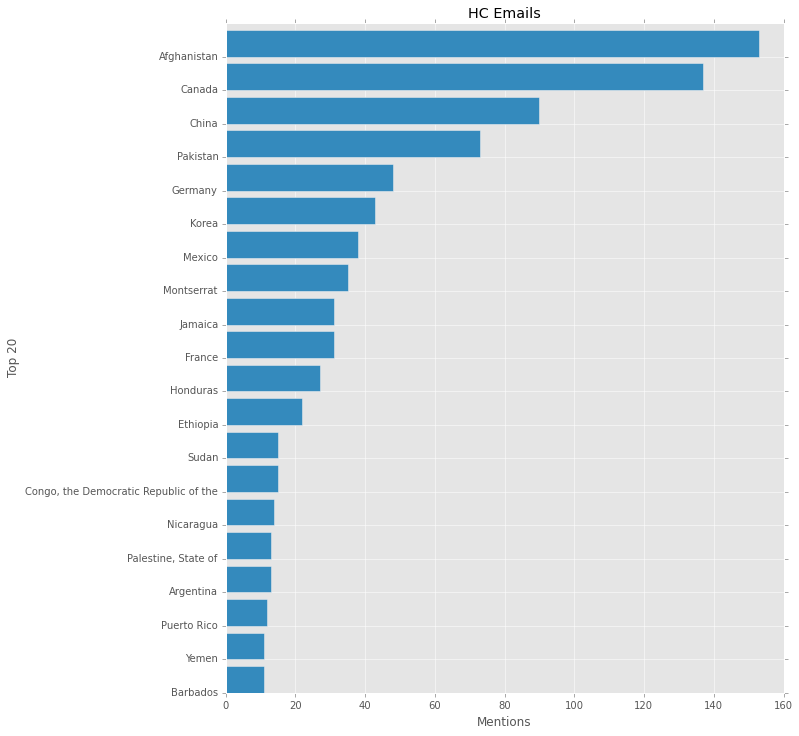

[('Afghanistan', 153), ('Canada', 137), ('China', 90), ('Pakistan', 73), ('Germany', 48), ('Korea', 43), ('Mexico', 38), ('Montserrat', 35), ('France', 31), ('Jamaica', 31), ('Honduras', 27), ('Ethiopia', 22), ('Congo, the Democratic Republic of the', 15), ('Sudan', 15), ('Nicaragua', 14), ('Argentina', 13), ('Palestine, State of', 13), ('Puerto Rico', 12), ('Barbados', 11), ('Yemen', 11)]


In [14]:
#https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb
#countriestoplot = sorted(list(countrycounter.items()), key=lambda x: x[1], reverse=True)[:20]
countriestoplot = sorted(countrycounter.most_common(20), key = lambda x: x[1])
y,x = zip(*countriestoplot)

plt.figure(figsize=(10,12))

plt.barh(list(range(len(x))), x)
plt.yticks(list(range(len(x))), y, ha='right')

plt.title('HC Emails')
plt.ylabel('Top 20')
plt.xlabel('Mentions')
plt.show()
print(countrycounter.most_common(20))

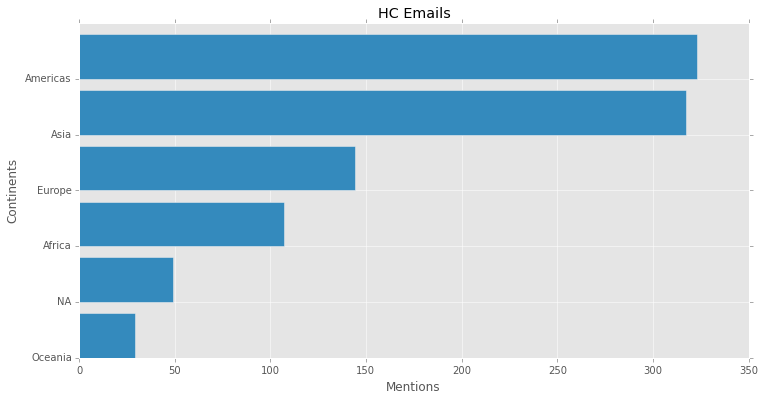

Counter({'Americas': 323, 'Asia': 317, 'Europe': 144, 'Africa': 107, 'NA': 49, 'Oceania': 29})


In [15]:
y,x = zip(*sorted(list(continentcounter.items()), key = lambda x: x[1]))

plt.figure(figsize=(12,6))

plt.barh(list(range(len(x))), x)
plt.yticks(list(range(len(x))), y, ha='right')

plt.title('HC Emails')
plt.ylabel('Continents')
plt.xlabel('Mentions')
plt.show()
print(continentcounter)

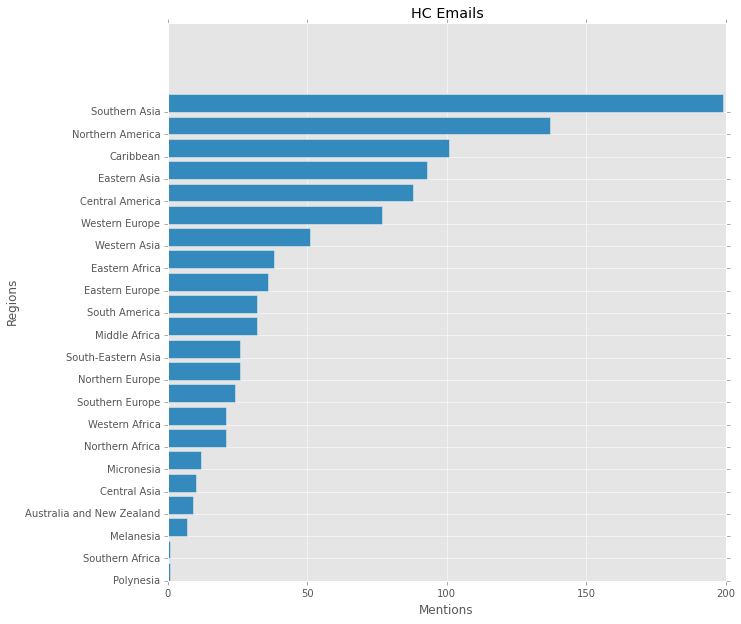

Counter({'Southern Asia': 199, 'Northern America': 137, 'Caribbean': 101, 'Eastern Asia': 93, 'Central America': 88, 'Western Europe': 77, 'Western Asia': 51, 'Eastern Africa': 38, 'Eastern Europe': 36, 'Middle Africa': 32, 'South America': 32, 'Northern Europe': 26, 'South-Eastern Asia': 26, 'Southern Europe': 24, 'Northern Africa': 21, 'Western Africa': 21, 'Micronesia': 12, 'Central Asia': 10, 'Australia and New Zealand': 9, 'Melanesia': 7, 'Polynesia': 1, 'Southern Africa': 1})


In [16]:
y,x = zip(*sorted(list(regioncounter.items()), key = lambda x: x[1]))

plt.figure(figsize=(10,10))

plt.barh(list(range(len(x))), x)
plt.yticks(list(range(len(x))), y, ha='right')

plt.title('HC Emails')
plt.ylabel('Regions')
plt.xlabel('Mentions')
plt.show()
print(regioncounter)

###Counting Countries, Continents and Regions per Year-Month

A similar counting as above but grouped by year-month.

In [22]:
#maxtime = datetime.datetime.strptime(df.SentFOIA.max(),"%Y-%M")
maxtime = datetime.date(int(df.SentFOIA.max()[:4]),int(df.SentFOIA.max()[5:7]), 1)
#print(maxtime)
#mintime = datetime.datetime.strptime(df.SentFOIA.min(),"%Y-%M")
mintime = datetime.date(int(df.SentFOIA.min()[:4]),int(df.SentFOIA.min()[5:7]), 1)
#print(mintime)
##http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html
##https://pymotw.com/2/datetime/
##http://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
#current = datetime.datetime(mintime.year, 12, 1)
#print(current)
#next_month = datetime.date(mintime.year + int(12 / 12), (int(12 % 12) + 1), 1)
#print(next_month)
dates = [mintime]
end = 0
print((maxtime-mintime).days)
next_month = mintime
#print(next_month)
while end==0:
    print((maxtime-next_month).days)
    if (maxtime - next_month).days <= 31:
        end = 1
    datetocheck = dates[-1]
    current = datetime.date(datetocheck.year, datetocheck.month, 1)
    next_month = datetime.date(datetocheck.year + int(datetocheck.month / 12), (int(datetocheck.month % 12) + 1), 1)
    dates.append(next_month)
dates



dateddata = dict([(d,[Counter(),Counter(),Counter(), Counter()]) for d in dates])


for ii, d in enumerate(df.SentFOIA):
    elem = foundpattern[ii]
    #print(elem)
    current = datetime.date(int(d[:4]),int(d[5:7]),1)
    if elem == []: continue
    donecontinentorregion = set()
    for e in elem:
        #print(e)
        dateddata[current][0].update([e[0]])
        dateddata[current][3].update([e[3]])
        if e[1] not in donecontinentorregion:
            dateddata[current][1].update([e[1]])
            donecontinentorregion.update([e[1]])
        if e[2] not in donecontinentorregion:
            dateddata[current][2].update([e[2]])
            donecontinentorregion.update([e[2]])



2160
2160
2129
2101
2070
2040
2009
1979
1948
1917
1887
1856
1826
1795
1764
1736
1705
1675
1644
1614
1583
1552
1522
1491
1461
1430
1399
1371
1340
1310
1279
1249
1218
1187
1157
1126
1096
1065
1034
1005
974
944
913
883
852
821
791
760
730
699
668
640
609
579
548
518
487
456
426
395
365
334
303
275
244
214
183
153
122
91
61
30


In [23]:
#maxtime = datetime.date(int(df.SentFOIA.max()[:4]),int(df.SentFOIA.max()[5:7]), 1)
#print(maxtime)
#mintime = datetime.datetime.strptime(df.SentFOIA.min(),"%Y-%M")
#print(mintime)
#df.SentFOIA.max()
#df['SentFOIA']
#dateddata

In [24]:
import operator
#sorted(dateddata[list(dateddata)[4]][0].items(), key=operator.itemgetter(1), reverse=True)
for elem in sorted(list(dateddata)):
    #my_list.sort(key=operator.itemgetter(1))
    print(elem,'-----',[x for x in [x[0] for i,x in enumerate(sorted(dateddata[elem][0].items(), key=operator.itemgetter(1), reverse=True)) if i <= 5]])
    #print(elem,'-----',[x for x in list(dateddata[elem][0])])


2009-01-01 ----- []
2009-02-01 ----- []
2009-03-01 ----- ['Mexico', 'Philippines', 'Korea', 'Canada', 'Afghanistan']
2009-04-01 ----- ['Afghanistan', 'Korea', 'Mexico', 'China', 'Canada', 'France']
2009-05-01 ----- ['Korea', 'China', 'Mexico', 'Afghanistan', 'Kazakhstan', 'Honduras']
2009-06-01 ----- ['Canada', 'Honduras', 'Afghanistan', 'China', 'Gabon', 'Korea']
2009-07-01 ----- ['Korea', 'Canada', 'China', 'Sudan', 'Pakistan', 'Ethiopia']
2009-08-01 ----- ['Canada', 'Honduras', 'Pakistan', 'Congo, the Democratic Republic of the', 'China', 'Afghanistan']
2009-09-01 ----- ['Afghanistan', 'Canada', 'Pakistan', 'China', 'Korea', 'Colombia']
2009-10-01 ----- ['Afghanistan', 'Canada', 'Sudan', 'Pakistan', 'Puerto Rico', 'Sierra Leone']
2009-11-01 ----- ['Afghanistan', 'Canada', 'Honduras', 'Pakistan', 'China', 'Germany']
2009-12-01 ----- ['Canada', 'Afghanistan', 'China', 'Pakistan', 'Estonia', 'Puerto Rico']
2010-01-01 ----- ['China', 'Jamaica', 'Afghanistan', 'Pakistan', 'Canada', 'Fran

Similar as above per continent.

In [25]:
for elem in sorted(list(dateddata)):
    #my_list.sort(key=operator.itemgetter(1))
    print(elem,'-----',[x for x in [x[0] for i,x in enumerate(sorted(dateddata[elem][1].items(), key=operator.itemgetter(1), reverse=True)) if i <= 6]])
    #print(elem,'-----',[x for x in list(dateddata[elem][0])])


2009-01-01 ----- []
2009-02-01 ----- []
2009-03-01 ----- ['Americas', 'Asia', 'NA']
2009-04-01 ----- ['Asia', 'Americas', 'Africa', 'NA', 'Europe']
2009-05-01 ----- ['Asia', 'NA', 'Americas', 'Europe', 'Africa', 'Oceania']
2009-06-01 ----- ['Americas', 'Asia', 'Europe', 'Africa', 'Oceania', 'NA']
2009-07-01 ----- ['Asia', 'Americas', 'Africa', 'NA']
2009-08-01 ----- ['Americas', 'Asia', 'Africa', 'Europe', 'NA', 'Oceania']
2009-09-01 ----- ['Asia', 'Americas', 'Africa', 'Europe', 'NA', 'Oceania']
2009-10-01 ----- ['Asia', 'Americas', 'Africa', 'Europe', 'NA']
2009-11-01 ----- ['Asia', 'Americas', 'Europe', 'Africa', 'NA']
2009-12-01 ----- ['Asia', 'Americas', 'Europe', 'Africa', 'Oceania']
2010-01-01 ----- ['Asia', 'Americas', 'Europe', 'Africa', 'Oceania', 'NA']
2010-02-01 ----- ['Americas', 'Asia', 'Europe', 'Oceania', 'Africa', 'NA']
2010-03-01 ----- ['Asia', 'Americas', 'Europe', 'Africa', 'Oceania']
2010-04-01 ----- ['Asia', 'Africa', 'Europe', 'Americas', 'NA']
2010-05-01 ----- [

Similar as above per region.

In [27]:
for elem in sorted(list(dateddata)):
    #my_list.sort(key=operator.itemgetter(1))
    print(elem,'-----',[x for x in [x[0] for i,x in enumerate(sorted(dateddata[elem][2].items(), key=operator.itemgetter(1), reverse=True)) if i <= 6]])
    #print(elem,'-----',[x for x in list(dateddata[elem][0])])


2009-01-01 ----- []
2009-02-01 ----- []
2009-03-01 ----- ['Central America', 'South-Eastern Asia', 'Southern Asia', 'Northern America']
2009-04-01 ----- ['Southern Asia', 'Central America', 'Northern America', 'Eastern Asia', 'Eastern Africa', 'Western Europe', 'South America']
2009-05-01 ----- ['Eastern Asia', 'Central America', 'Southern Asia', 'Eastern Europe', 'Central Asia', 'Eastern Africa', 'Melanesia']
2009-06-01 ----- ['Northern America', 'Southern Asia', 'Central America', 'Eastern Asia', 'Middle Africa', 'Southern Europe', 'Caribbean']
2009-07-01 ----- ['Southern Asia', 'Northern America', 'Eastern Asia', 'Northern Africa', 'Eastern Africa', 'South America', 'Middle Africa']
2009-08-01 ----- ['Northern America', 'Southern Asia', 'Central America', 'Middle Africa', 'Eastern Asia', 'Western Europe', 'Eastern Africa']
2009-09-01 ----- ['Southern Asia', 'Northern America', 'Eastern Asia', 'Eastern Africa', 'Western Europe', 'Middle Africa', 'South America']
2009-10-01 ----- ['So

In [28]:
import json
json_output_countries = []
for elem in dateddata.items():
    #print(elem)
    #break
    json_output_countries.append({"dt":str(elem[0])[:10], "ct":elem[1][3]})

json_output_countries[:5]

with open('/home/ec/Public/kaggle/hc_emails/output/json_output_countries2.json','w') as fout:
    json.dump(json_output_countries,fout)

##Conclusions:
* It is easy to see how the attention swifted between months to different countries according to main events that occured during the specific period. For example:
  * 2009 was Aghanistan
  * 2010 was Haiti
  * 2011-2012 was the Arab Spring and Lybia
* The focus of emails concentrated on regions in conflict of different nature. Those regions that were considered in serious conflict that involved USA received more attention. LatinAmerica was first, then regions around Aghanistan and then the region where the Arab Spring occurred.
* The messaging also involved the mentioning of countries that were considered allies to USA, with a strong focus on Israel and Oman, but also Western Europe and OTAN, as well as Pakistan, India, Japan, South Korea and Australia. In Latinamerica, Central America, Peru, Colombia and Brazil seemed to receive special mentioning.
* This results are just a first overview and far to be correct. The reasons of lack of veracity are not only because of the data itself but also the methodology used here. Specifically about the methodology, bear in mind that:
  * there is an unknown number of false positives as well as false negatives when approaching the search using this parsing and the modified country dataset used for the search.
  * some emails contained relevant information about countries in other forms: personalities (which could be directed related to an event in a country or region), or cities/capitals instead of countries (eg. Benghazi).

##Non-negative Matrix Factorization (NMF)
The following follows part of the work by Doug Kelly (https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb)

In [29]:
#from https://github.com/dougkelly/TopicModeling_HilaryClintonEmails/blob/master/Final_Project_DK_HilaryClintonEmails.ipynb
def email_cleanup(email):
    """
    Cleaning up raw text of emails
    """
    # Normalizing tokens by lower casing
    email = email.replace('\n', " ").lower()

    patterns = [
    # # Remove From: LastName, FirstName, Optional Middle Initial
    r"from: (\w+), (\w+) (\w+)?",
    # Dates
    r"(date):? \d+/\d+/\d+",
    # # Remove Case Numbers. Example: Case No. F-2015-04841
    r"case no. \w-\d+-\d+",
    # # Remove times. Example: 12:08 PM
    r"[0-2]?[0-9]:[0-6][0-9] (am|pm)",
    # Removing Timestamps in Sent
    r"(sent|updated)?:? (monday|tuesday|wednesday|thursday|friday|saturday|sunday), (january|february|march|april|may|june|july|august|september|october|november|december) \d+, \d{4} \d{0,2}:\d{0,2} (am|pm)",
    # Remove emails
    r"[\w]+@[\.\w]+",
    # Dates 2
    r"(monday|tuesday|wednesday|thursday|friday|saturday|sunday)",
    # Removing months
    r"january|february|march|april|may|june|july|august|september|october|november|december",
    # Removing doc numbers
    r"doc no. \w?\d+",
    # Removing email footer STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
    r"state dept. - produced to house select benghazi comm.",
    # Removing email footer SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS.
    r"subject to agreement on sensitive information & redactions.",
    # Removing email footer
    r"no foia waiver.",
    # Removing leftover characters
    r"[\@!<>()&-:';]",
    # remove all digits
    #r"\d"
    ]
    
    for pattern in patterns:
        email = re.sub(pattern, " ", email)
    return email



def tags_filter(text):
    """
    Experiment to just use Nouns, Verbs, Adjectives
    """
    blob = TextBlob(text).tags
    #words = []
    for blob_tags in blob:
        # Nouns
        if blob_tags[1] in ("NN", "NNS", "NNP", "NNPS"):
            words.append(blob_tags[0])
        # Verbs
        if blob_tags[1] in ("VB", "VBD", "VBG", "VBN", "VBP", "VBZ"):
            words.append(blob_tags[0])
        # Adj
#         if blob_tags[1] in ("RB", "RBR", "RBS"):
#             words.append(blob_tags[0])
        words = [w for w in words if len(w) > 1]

    return " ".join(words)



In [30]:
#Using only nouns...
def tags_filter(tks):
    return ' '.join([tk[0] for tk in tks if tk[1] in ("NN", "NNS", "NNP", "NNPS")])

In [31]:
#df['EmailBody'] = df['EmailBody'].apply(email_cleanup)
df['EmailBodyTokens'] = df['EmailBody'].apply(tags_filter)

In [32]:
X = df['EmailBodyTokens']

# Experimented with increasing max features (the maximum number of words or phrases that are included in the vector model) to improve topic clarity
# Removed English stopwords
#cv = CountVectorizer(max_features=10000, stop_words = ['stopword'], ngram_range=(1, 2), max_df=0.98)
cv = CountVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.98)
cv_X = cv.fit_transform(X)
# print vectorized_X.toarray()
# Saving words
word_col = cv.get_feature_names()
word_col[:10]



['01',
 '05',
 '0666409185621',
 '0666409185621 b4336495',
 '09',
 '133705',
 '133705 0666409185621',
 '15',
 '1990s',
 '2014']

###Selection of number of components by the Elbow Method

In [33]:
from scipy import sparse

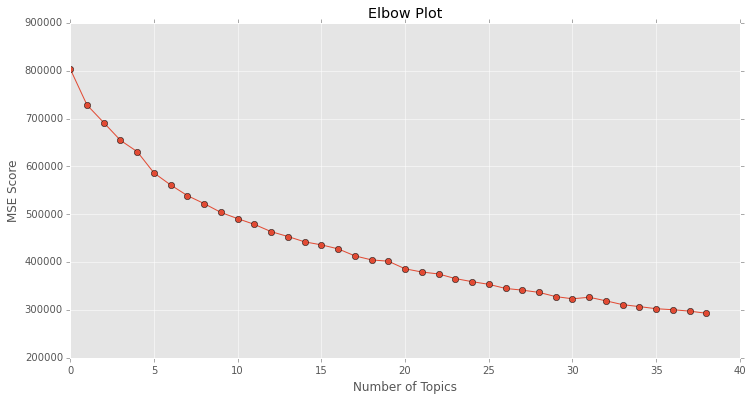

In [71]:
plt.figure(figsize=(12,6))
plt.title("Elbow Plot")
plt.xlabel("Number of Topics")
plt.ylabel("MSE Score")
errors = []
for k in range(1,40):
    nmf = NMF(n_components=k).fit(cv_X)
    W = nmf.fit_transform(cv_X);
    H = nmf.components_
    predicted = sparse.csr_matrix(W.dot(H))
    og_sparse = sparse.csr_matrix(cv_X)
    diff = numpy.absolute(og_sparse - predicted)
    errors.append(numpy.sum(numpy.square(diff.data)))
plt.plot(numpy.arange(k), errors, c='r', linestyle='-', marker= 'o');



In [84]:
nmf = NMF(n_components=35).fit(cv_X)
W = nmf.fit_transform(cv_X);
H = nmf.components_



In [85]:
# W (n_emails, n_topics)
W.shape


(6737, 35)

In [86]:
# H (n_topics, n_features)
H.shape

(35, 10000)

###Evaluating components against MetadataSubject as way to analysize accuracy

In [87]:
# emails_topic
emails_topic = pandas.DataFrame(W)
#emails_topic



In [88]:
def topic_EmailsPerMonth(topic, doc_topic, X):
    """
    Function to return count of emails with topic per year
    """
    # All emails that contain topic
    emails_with_topic = doc_topic[:,topic].nonzero()
    # 
    emails_with_topic = X[['SentFOIA','MetadataSubject']].ix[emails_with_topic]
    emails_year_topic = emails_with_topic.groupby('SentFOIA').apply(len)
    emails_year_topic.plot(kind='barh', color='green', title='Topic {:}: Emails Counts by Year'.format(topic))
    plt.ylabel('Month', rotation=0)
    print('Topic {}: {:.2%} of total emails'.format(topic, emails_year_topic.sum() / 7994.0))
    print(emails_year_topic)

Topic 5: 14.82% of total emails
SentFOIA
2009-03      5
2009-04     25
2009-05     48
2009-06     44
2009-07     58
2009-08     59
2009-09     90
2009-10     64
2009-11     75
2009-12     74
2010-01     85
2010-02     72
2010-03     53
2010-04     45
2010-05     66
2010-06     53
2010-07     33
2010-08     60
2010-09     40
2010-10     38
2010-11     22
2010-12     33
2011-03      3
2011-04      5
2011-05      2
2011-06      2
2011-09      1
2012-01      3
2012-03      2
2012-04      2
2012-07      2
2012-09      9
2012-10      7
2012-11      3
2012-12      2
dtype: int64


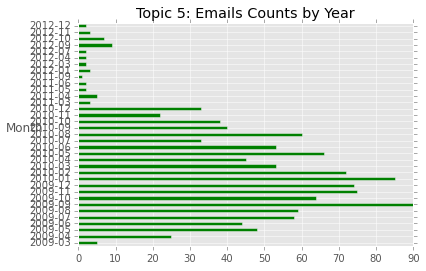

In [89]:
topic_EmailsPerMonth(5, W, df)

In [90]:
# Top Emails by Topic
def topic_topEmails(topic, n_emails, X, doc_topics):
    topN_topic_email = doc_topics[:,topic].argsort()[::-1][:n_emails]
    return X[['SentFOIA','MetadataSubject']].ix[topN_topic_email]

In [91]:
topic_topEmails(7, 10, df, W)

,SentFOIA,MetadataSubject
6629,2012-09,CGI DRAFT V3 092212.DOCX
6666,2012-10,SPEECH DRAFT FOR FRIDAY AT CSIS
6615,2012-09,"RICE ON ""THIS WEEK"""
6477,2011-03,H: LOTS OF NEW INTEL; POSSIBLE LIBYAN COLLAPSE...
6628,2012-09,LIBYA
6508,2011-08,JEFF UPDATE
6474,2011-03,PIECE ON LIBYA NFZ THAT WILL APPEAR ON NYT OP-...
6704,2012-11,AN OP-ED YOU SHOULD READ; PRAISES STATE FOR WH...
6583,2012-09,CNN BELIEF BLOG. PROTHERO
6724,2012-12,"H: SURE YOU'VE SEEN ALL THIS INFO, BUT START O..."


In [92]:
# Referenced NMF package doc pages for plot ideas: http://nimfa.biolab.si/nimfa.examples.documents.html
def topic_TopWords(model, feature_names, n_top_words):
    """
    Function for printing % words contained by topic, n_top_words sorted by length,
    and plots top 10 words by importance per topic
    """
    for topic_idx, topic in enumerate(model.components_):
        
        print("\n Topic {}: \n".format(topic_idx+1))
        print("Percentage of Words: {:.2%}\n".format(numpy.count_nonzero(topic) / 41961.))
        top_words = [feature_names[i] for i in topic.argsort()[::-1][:n_top_words]]
        print(' '.join(sorted(top_words,key=len,reverse=True)))
        top10_idx = topic.argsort()[::-1][:10]
        value = sorted(topic[top10_idx],reverse=False)
        
        # Horizontal Bar Plots of Top 10 weighted terms
        plt.figure(topic_idx + 1)
        plt.barh(numpy.arange(10) + .5, value, color="green", align="center")
        plt.yticks(numpy.arange(10) + .5, [feature_names[i] for i in topic.argsort()[::-1][:10]])
        plt.xlabel("Weight")
        plt.ylabel("Term")
        plt.title("Top 10 Highest Weighted Terms in Topic {}".format(topic_idx + 1))
        plt.grid(True)
        plt.show()




 Topic 1: 

Percentage of Words: 8.59%

agreement information benghazi agreement select benghazi c05739812 date united states doc c05739812 house select information date house government agreement c05739812 benghazi case doc violence people united states select house world today case date doc


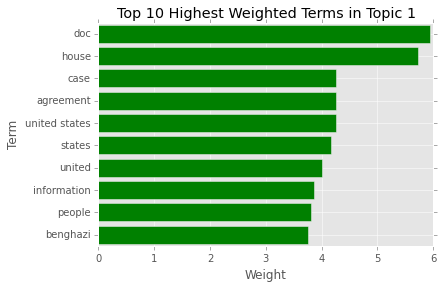


 Topic 2: 

Percentage of Words: 7.46%

republicans republican democrats alexander committee senators majority senator members chamber senate reform corker debate floor house party rules udall bill vote dodd time days year


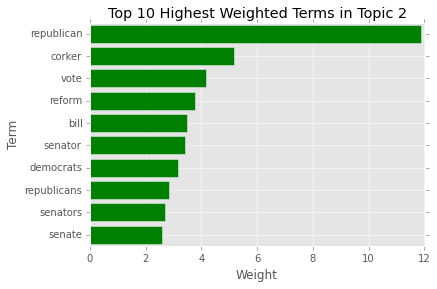


 Topic 3: 

Percentage of Words: 9.06%

americans prosperity koch industries david koch industries prosperity government americans president institute brothers movement charles company dollars million center family cancer people kochs david obama party group koch


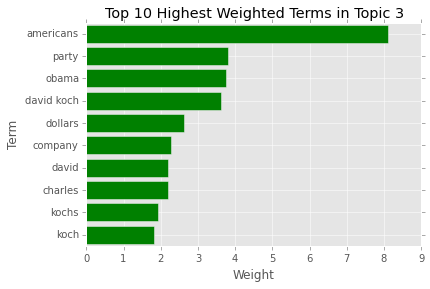


 Topic 4: 

Percentage of Words: 6.09%

counterinsurgency mcchrystal eikenberry operations president commander soldiers strategy official pentagon taliban command troops forces karzai people obama years staff year team coin afg irq gen


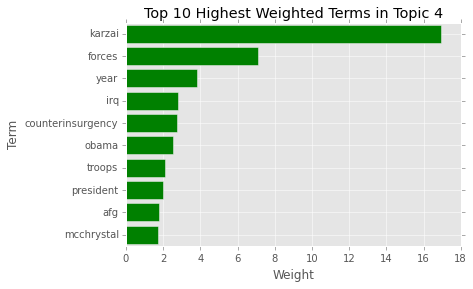


 Topic 5: 

Percentage of Words: 6.15%

secretary conference private residence meeting secretary secretary office conference room time secretary staff meeting office time conference secretary residence depart en en route meeting private airport office arrive depart route daily staff room time en


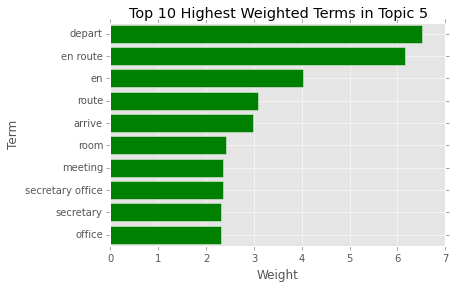


 Topic 6: 

Percentage of Words: 6.27%

general mcchrystal afg security army police government equipment security afg army fighters minister officers taliban general leaders country forces police troops nation effort karzai army year afg irq isi


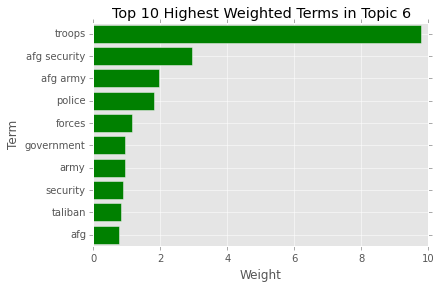


 Topic 7: 

Percentage of Words: 8.27%

white house branch wjc president lewinsky moynihan north na wjc gore clinton hillary branch carter people house north white gore book reno life time wjc hrc cvc hti na


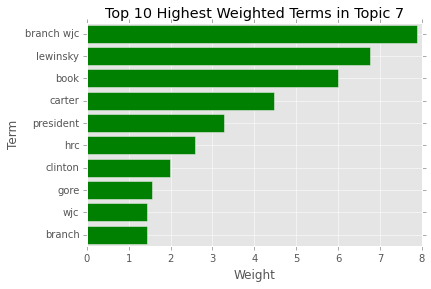


 Topic 8: 

Percentage of Words: 5.36%

agreement information benghazi agreement information state select benghazi c05739767 date c05739661 date information b5 doc c05739767 doc c05739661 house select information date house agreement c05739767 c05739661 benghazi case doc b5 case select house state case date doc b5


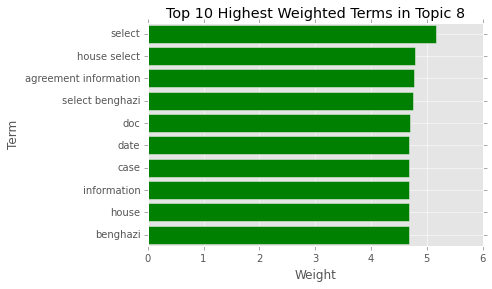


 Topic 9: 

Percentage of Words: 7.09%

favorable unfavorable unfavorable hv unfavorable hv refused favorable president worn wht ind worn percent refused opinion rep dem dem ind degree romney obama palin worn vol wht ind rep dem nov hv


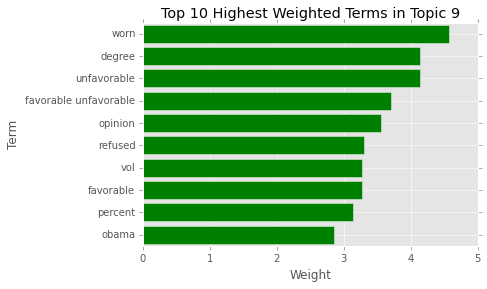


 Topic 10: 

Percentage of Words: 7.30%

presidential election preliminary analysis irn presidential chathamhouse org www chathamhouse analysis voting voting figures presidential chathamhouse election www ahmadinejad preliminary figures irn provinces election analysis province figures voters voting org uk irn org www uk


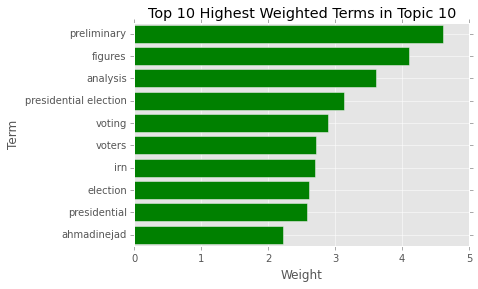


 Topic 11: 

Percentage of Words: 6.18%

health care republicans republican healthcare government president movement abortion campaign skousen america stupak reform health people hitler obama party palin death right group beck bill care


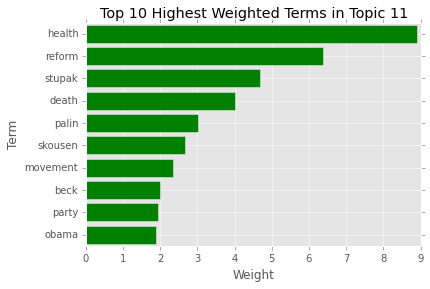


 Topic 12: 

Percentage of Words: 5.59%

gender equality development conference afg women women afg coalition equality children security america gender rights health karzai issues united women peace world girls years issue work time afg


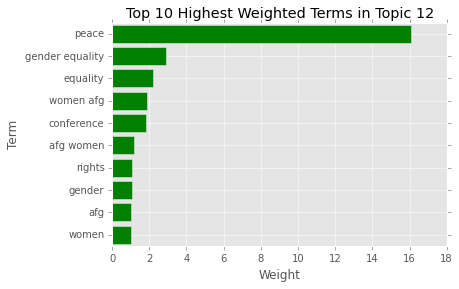


 Topic 13: 

Percentage of Words: 6.93%

united states peace process palestinians palestinian middle east netanyahu jerusalem ambiguity american security israelis israeli process jewish states united middle peace arabs hagee arab east time jews isr


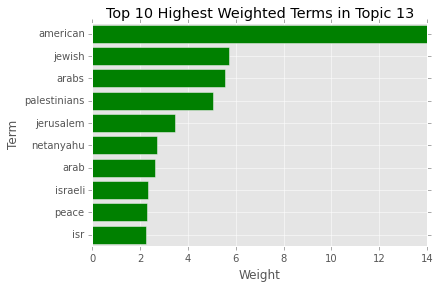


 Topic 14: 

Percentage of Words: 9.39%

hill academy georgetown ashawntea students domenici district carleto student academy schools percent school forman change police teens years youth adams staff hill kids room time city


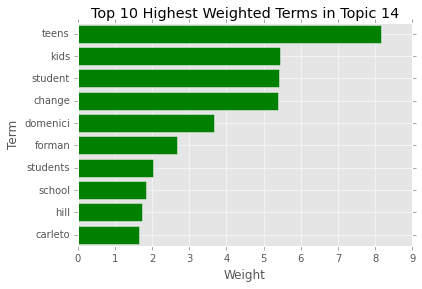


 Topic 15: 

Percentage of Words: 6.58%

justice powers northern irl devolution government mcguinness sinn fein agreement northern unionist politics minister justice cameron powers ulster leader party empey deal fein sinn vote irl uup dup


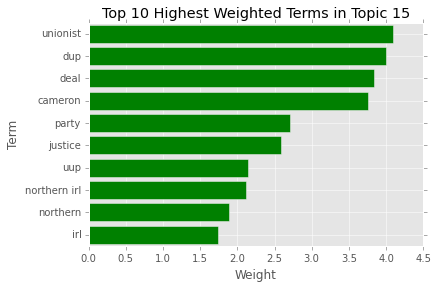


 Topic 16: 

Percentage of Words: 8.84%

united states postconflict development government diplomacy diplomats secretary officials conflict security american dobbins efforts united states effort forces people force smith time irq fco mod afg


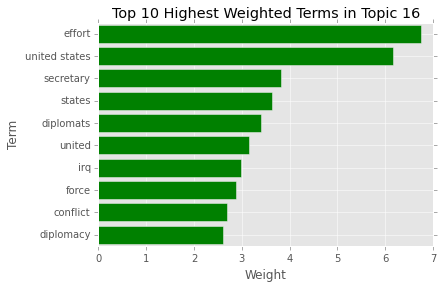


 Topic 17: 

Percentage of Words: 7.21%

united states relationship instability countries democracy interest exchange chinese towards dynasty country policy states united growth demand assets world years asia rate time chn sgp ind


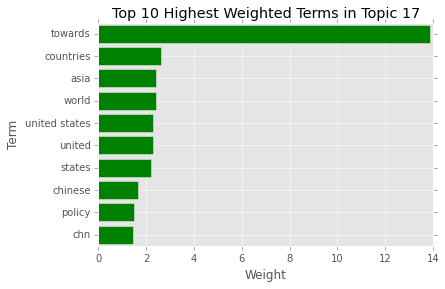


 Topic 18: 

Percentage of Words: 6.16%

ms gillibrand conversation mr richards gillibrand mr boehner bloomberg president richards campaign mr ford support donors jagger heyman keith mayor money ford york book life city time mr ms


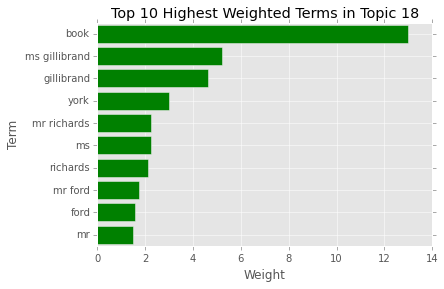


 Topic 19: 

Percentage of Words: 9.94%

maquiladoras authorities government gonzalez evidence violence murders el paso workers juarez people sharif police rascon murder policy garcia women group ponce woman city lear paso el


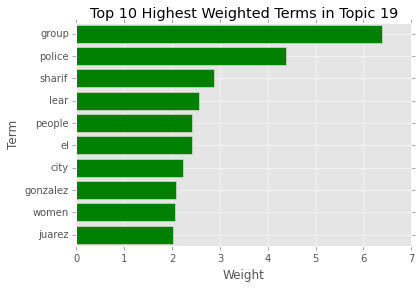


 Topic 20: 

Percentage of Words: 8.52%

administration agriculture development opportunity scientists president countries approach training farmers systems support people policy africa hunger health world prize women obama ejeta food need dr


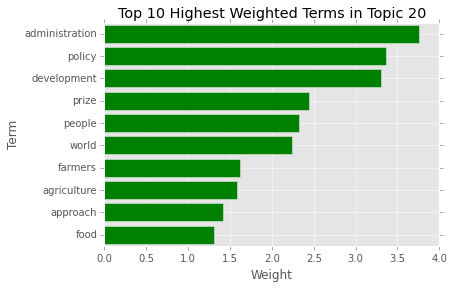


 Topic 21: 

Percentage of Words: 7.17%

administration white house wall street presidency washington president stimulus politics geithner populism strategy campaign security program street carter public policy obama white house times wall week year


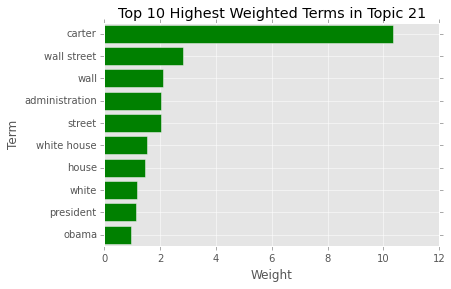


 Topic 22: 

Percentage of Words: 7.82%

united states assistance government hemisphere commitment progress nations haitian economy support efforts january people united states nation health region growth media years jobs work drug hti


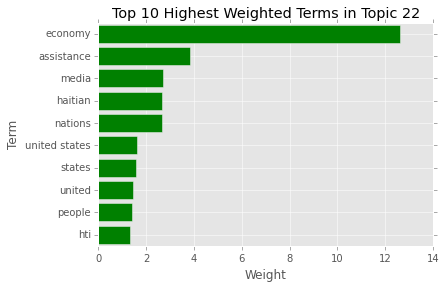


 Topic 23: 

Percentage of Words: 4.22%

democrats percent percent approval percent percent approval rating rating percent independents republicans health care disapproval democrats americans president secretary approval congress handling percent economy numbers voters rating health obama poll care


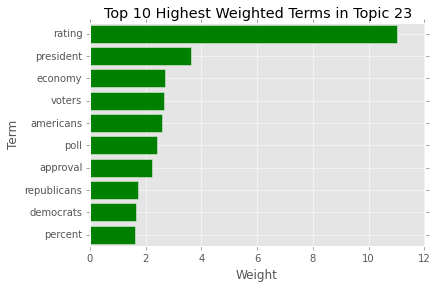


 Topic 24: 

Percentage of Words: 7.40%

north waziristan child marriage administration united states waziristan ambassador government pakistani marriage abortion thursday taliban united groups states child house north issue girls bill army pak ind isi


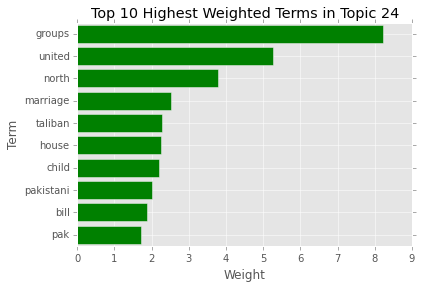


 Topic 25: 

Percentage of Words: 6.48%

approve disapprove states senator united states wtbrnagn rep disapprove wtbrnagn senator approve portman brunner percent rep dem states united fisher ganley trend ohio vote else worn vol jul rep ind


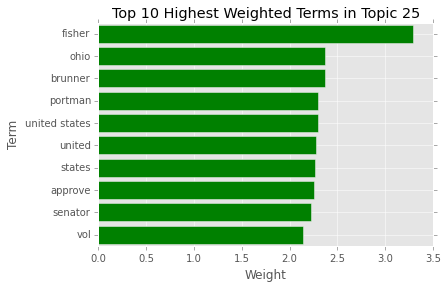


 Topic 26: 

Percentage of Words: 5.47%

john boehner republicans mr boehner republican government washington nowakowski interests americans lobbyists democrats boehner speaker message voters people attack leader pelosi house staff party john rove beat


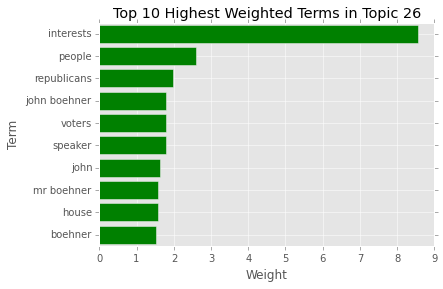


 Topic 27: 

Percentage of Words: 6.99%

washington convention convention center room washington spray bilateral bilateral room center camera seasons hotel camera spray four seasons washington convention bilateral minister seasons plenary center camera depart arrive spray hotel press room four en


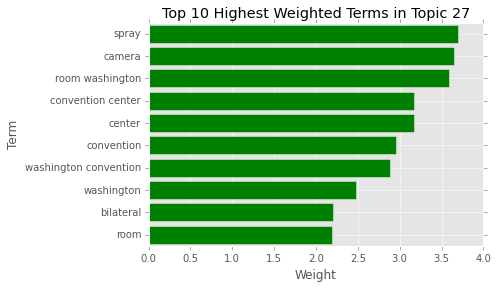


 Topic 28: 

Percentage of Words: 6.35%

ambassador eikenberry general petraeus administration mr holbrooke white house ambassador eikenberry washington mcchrystal holbrooke officials president petraeus general crocker karzai allies white house kabul call role afg pak mr


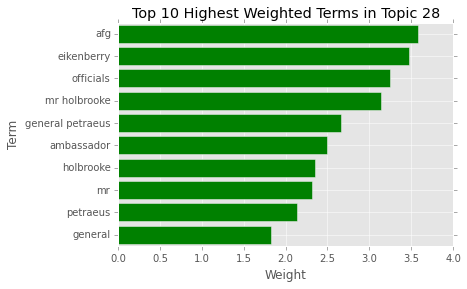


 Topic 29: 

Percentage of Words: 8.01%

sunday times parliament government election minister cameron support parties labour tories sunday points voters change times party brown david today cent poll tory week news lead


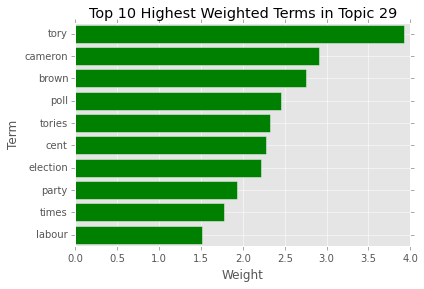


 Topic 30: 

Percentage of Words: 7.94%

revolutionary guards revolutionary intelligence government kurdistan americans american official iranian officer kurdish border hikers guards report region shourd fattal bauer iraqi taab pjak july irn irq


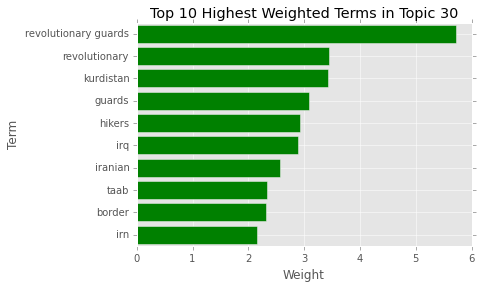


 Topic 31: 

Percentage of Words: 9.33%

community campaign american chernick israeli network islamic wilders cordoba project center geller muslim school jewish boston groups group years times david york city jews isr


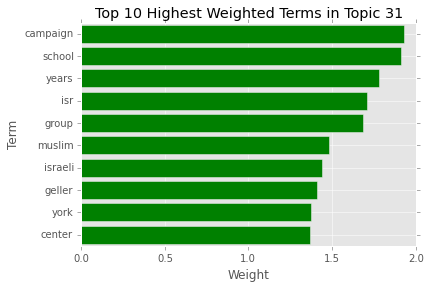


 Topic 32: 

Percentage of Words: 9.65%

sullivanjj state millscd state abedinh state huma abedinh abedin huma sullivanjj state gov wednesday thursday saturday millscd abedinh abedin hrod17 monday friday sunday august state jacob huma gov hrc min b6


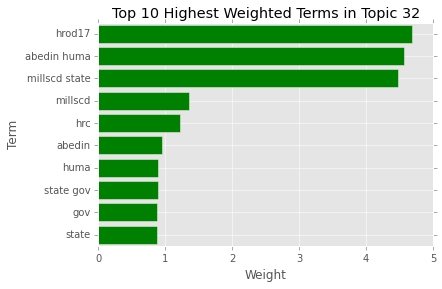


 Topic 33: 

Percentage of Words: 7.76%

obama administration hillary clinton administration white house washington president secretary diplomacy security clinton hillary adviser policy issues george obama world power white trip role east bush bra irn


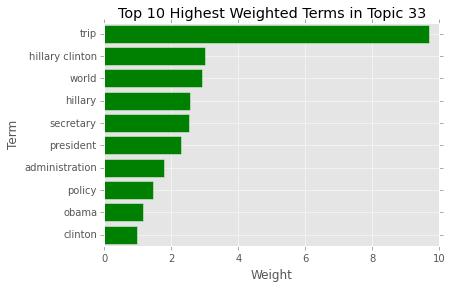


 Topic 34: 

Percentage of Words: 6.50%

prescription drug prescription white house health care care reform washington committee president democrats industry medicare congress chairman health baucus reform tauzin house white phrma care drug deal bill cost


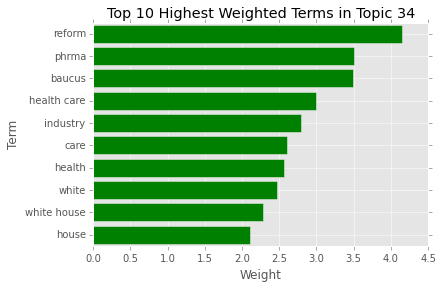


 Topic 35: 

Percentage of Words: 7.97%

birch society conservatives republicans republican government john birch president democrats americans american national politics buckley society skousen country reagan party birch right nixon beck year john bush


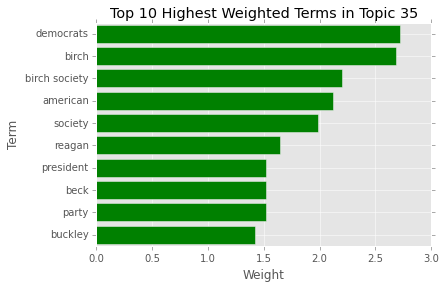

In [93]:
topic_TopWords(nmf, word_col, 25)

In [94]:
end the project here

SyntaxError: invalid syntax (<ipython-input-94-54684e8a6d94>, line 1)

##LDA

In [ ]:
def word_clouds(model, word_list, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\n Topic {}: \n".format(topic_idx+1))
        topic_wordlist = [word_list[i] for i in model.components_[topic_idx].argsort()[::-1][:n_top_words]]
        topic_words = ' '.join(topic_wordlist)
        print(topic_words)
        #wordcloud = WordCloud(max_font_size=80,relative_scaling=.5,width=800,height=500).generate(topic_words)
        #plt.imshow(wordcloud)
        #plt.axis("off")
        #plt.show()

In [ ]:
# Source Code: https://github.com/scikit-learn/scikit-learn/tree/master/sklearn/decomposition
# Docs: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda_params = {'n_topics':[1,5,10,20,50]}
lda = LatentDirichletAllocation()
lda_grid = GridSearchCV(lda, lda_params)

In [ ]:
lda_grid.fit(cv_X)
lda_grid.best_estimator_

In his work, G Kelly found that the LDA converged on 5 topics after few runs, indicating that LDA is unable to disentangle by topics when several emails seem to relate to different ones. Also, G Kelly mentions that LDA does not handle short length of documents well. He suggests that an area to explore would be seeding with prior distributions of words for topics.


In [ ]:
lda_model = LatentDirichletAllocation(n_topics=5, n_jobs=-1).fit(cv_X)

In [ ]:
doctopic = lda_model.fit_transform(cv_X)

In [ ]:
def topic_EmailsPerMonth(topic, doc_topic, X):
    """
    Function to return count of emails with topic per year
    """
    # All emails that contain topic
    emails_with_topic = doc_topic[:,topic].nonzero()
    # 
    emails_with_topic = X[['SentFOIA','MetadataSubject']].ix[emails_with_topic]
    emails_year_topic = emails_with_topic.groupby('SentFOIA').apply(len)
    print(emails_year_topic)
    emails_year_topic.plot(kind='barh', color='red', title='Topic {:}: Emails Counts by Month'.format(topic))

In [ ]:
def topic_TopWords(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\n Topic {}: \n".format(topic_idx+1))
        top_words = [feature_names[i] for i in topic.argsort()[::-1][:n_top_words]]
        print(' '.join(sorted(top_words,key=len,reverse=True)))

In [ ]:
topic_TopWords(lda_model,word_col,25)

In [ ]:
lda_model.score(cv_X)

In [ ]:
word_clouds(lda_model, word_col, 50)